# Sentinel-2 downloader and circular field counter
This notebook downloads Sentinel-2 imagery and processes its data to count the amount of visible circular fields

In [36]:
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import datetime
import zipfile
from os import listdir
from os.path import isfile, join

api = SentinelAPI('username', 'password')
footprint = geojson_to_wkt(read_geojson('saudi_arabia.geojson'))
products = api.query(footprint,
                     date = (datetime(2018, 5, 5), datetime.now().date()),
                     platformname = 'Sentinel-2',
                     cloudcoverpercentage = (0, 0))

downloadSuccess, downloadError = api.download_all(products)
for key, value in downloadSuccess.items():
    zip_ref = zipfile.ZipFile(value.get('path'), 'r')
    zip_ref.extractall('.')
    zip_ref.close()

In [3]:
from snappy import (ProductIO, ProductUtils, ProductData, Product, FlagCoding, ProgressMonitor)
import snappy
import sys
import matplotlib.pyplot as plt
import os.path
import matplotlib.image as mpimg
import numpy as np

jpy = snappy.jpy

# More Java type definitions required for image generation
Color = jpy.get_type('java.awt.Color')
ColorPoint = jpy.get_type('org.esa.snap.core.datamodel.ColorPaletteDef$Point')
ColorPaletteDef = jpy.get_type('org.esa.snap.core.datamodel.ColorPaletteDef')
ImageInfo = jpy.get_type('org.esa.snap.core.datamodel.ImageInfo')
ImageLegend = jpy.get_type('org.esa.snap.core.datamodel.ImageLegend')
ImageManager = jpy.get_type('org.esa.snap.core.image.ImageManager')
JAI = jpy.get_type('javax.media.jai.JAI')
RenderedImage = jpy.get_type('java.awt.image.RenderedImage')

# Disable JAI native MediaLib extensions 
System = jpy.get_type('java.lang.System')
System.setProperty('com.sun.media.jai.disableMediaLib', 'true')

# to write images
def write_rgb_image(bands, filename, format):
    image_info = ProductUtils.createImageInfo(bands, True, ProgressMonitor.NULL)
    im = ImageManager.getInstance().createColoredBandImage(bands, image_info, 0)
    JAI.create("filestore", im, filename, format)
    
def get_ndvi_product(file):
    product = ProductIO.readProduct(file)
        
    width = product.getSceneRasterWidth()
    height = product.getSceneRasterHeight()
    name = product.getName()
    band_names = product.getBandNames()

    b4 = product.getBand('B4')
    b8 = product.getBand('B8')
    ndviProduct = Product('NDVI', 'NDVI', width, height)
    ndviBand = ndviProduct.addBand('ndvi', ProductData.TYPE_FLOAT32)
    ndviFlagsBand = ndviProduct.addBand('ndvi_flags', ProductData.TYPE_UINT8)
    writer = ProductIO.getProductWriter('BEAM-DIMAP')

    ProductUtils.copyGeoCoding(product, ndviProduct)

    ndviFlagCoding = FlagCoding('ndvi_flags')
    ndviFlagCoding.addFlag("NDVI_LOW", 1, "NDVI below 0")
    ndviFlagCoding.addFlag("NDVI_HIGH", 2, "NDVI above 1")
    group = ndviProduct.getFlagCodingGroup()
    #print(dir(group))
    group.add(ndviFlagCoding)

    ndviFlagsBand.setSampleCoding(ndviFlagCoding)

    ndviProduct.setProductWriter(writer)
    ndviProduct.writeHeader(name + 'output.dim')

    r4 = np.zeros(width, dtype=np.float32)
    r8 = np.zeros(width, dtype=np.float32)
    
    total = np.zeros(width, dtype=np.float32)


    print("Writing...")

    for y in range(height):
        #print("processing line ", y, " of ", height)
        r4 = b4.readPixels(0, y, width, 1, r4)
        r8 = b8.readPixels(0, y, width, 1, r8)

        ndvi = (r8 - r4) / (r8 + r4)
        ndviBand.writePixels(0, y, width, 1, ndvi)
        total += ndvi
        ndviLow = ndvi < 0.0
        ndviHigh = ndvi > 1.0
        ndviFlags = np.array(ndviLow + 2 * ndviHigh, dtype=np.int32)
        ndviFlagsBand.writePixels(0, y, width, 1, ndviFlags)

    ndviProduct.closeIO()   
    print("... done")
    
    return ndviProduct
    
for f in os.listdir('./'):
    if f.endswith('S2B_MSIL1C_20180508T080609_N0206_R078_T37RDP_20180508T115609.SAFE'):
        ndviProduct = get_ndvi_product(f)

Writing...


/Users/felix/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in divide
/Users/felix/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in less
/Users/felix/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in greater


... done


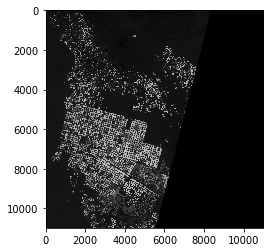

In [14]:
def write_image(band, filename, format):
    print ImageManager.getInstance()
    im = ImageManager.getInstance().createColoredBandImage([band], band.getImageInfo(), 0)
    JAI.create("filestore", im, filename, format)

productName = ndviProduct.getName()
ndviProduct = ProductIO.readProduct(os.path.join(os.getcwd(), './' + productName + '.dim'))

filename =  productName + '_ndvi.png'
        
band = ndviProduct.getBand('ndvi')

points = [ColorPoint(0.0, Color.BLACK), 
    ColorPoint(1.0, Color.WHITE)]
cpd = ColorPaletteDef(points)
ii = ImageInfo(cpd)
band.setImageInfo(ii)

if not os.path.exists(os.path.join(os.getcwd(), filename)):
    write_image(band, os.path.join(os.getcwd(), filename), 'PNG')

plt.imshow(mpimg.imread('./' + filename))
plt.show()

## Counting the features using scikit-image
#### Steps:
1. Convert to bw image
2. Apply treshold to get binary image
3. Run blob detection
4. Count blobs and output file

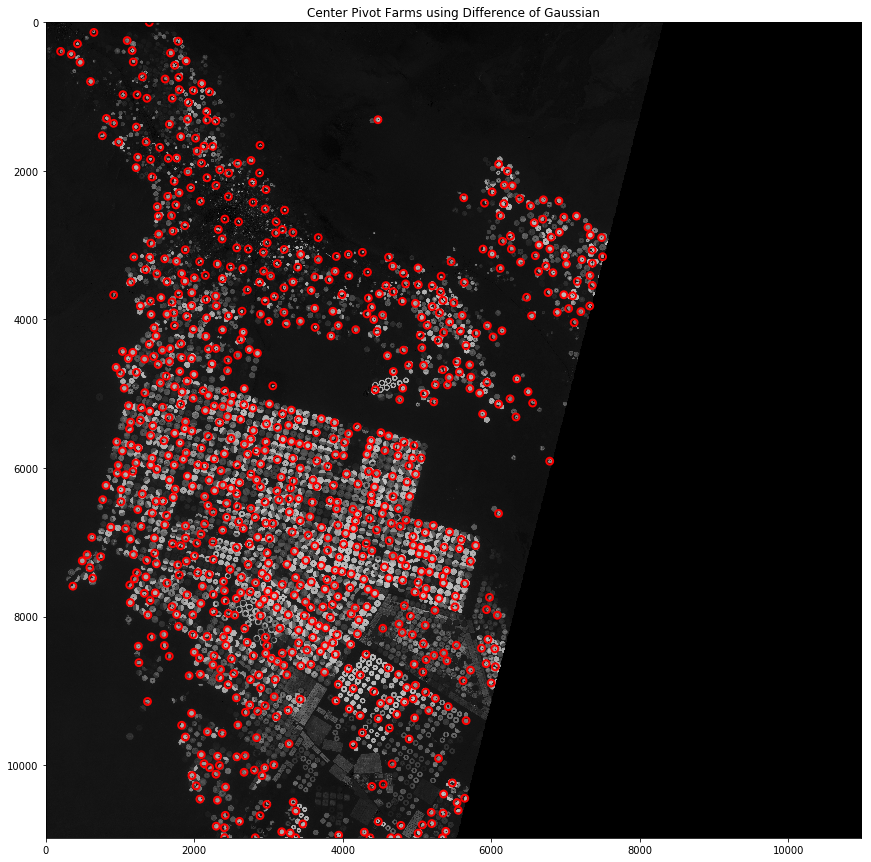

852


In [41]:
from  skimage import feature, color
from scipy.signal import convolve2d
from skimage.filters import threshold_otsu, threshold_local
from skimage.filters import threshold_minimum


img = mpimg.imread('./' + filename)

bw = img.mean(axis=2)

#fig, ax = plt.subplots(1, 1, figsize=(10, 10))

fig=plt.figure(figsize = (15,15))
ax=fig.add_subplot(1,1,1)

binary = bw > threshold_minimum(bw)

blobs_dog = [(x[0],x[1],x[2]) for x in feature.blob_dog(binary, 
                                                        min_sigma=45, 
                                                        max_sigma=55,
                                                        threshold=0.7,
                                                        overlap=0.2)]

#remove duplicates
blobs_dog = set(blobs_dog)

img_blobs = color.gray2rgb(img)

for blob in blobs_dog:
    y, x, r = blob
    c = plt.Circle((x, y), r+1, color='red', linewidth=2, fill=False)
    ax.add_patch(c)

plt.imshow(img_blobs, cmap=plt.cm.gray)
plt.title('Center Pivot Farms using Difference of Gaussian')

plt.show()

print str(len(blobs_dog))